## Scenario Analysis for a 100% renewable electricity system in Chile

In [280]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import pypsa
import numpy as np

In [281]:
# Projection to be used for all calculations
# ESRI:102033: South_America_Albers_Equal_Area_Conic
c = "ESRI:102033"

In [403]:
chile_regions = gpd.read_file("./data/chile_regions.gpkg", layer="chile_regions").to_crs(c).rename(columns = {"NAME_1":"region"})
aggregated_regions = gpd.read_file("./data/aggregated_regions.gpkg").rename(columns={'NAME_1': 'aggRegion'}).to_crs(c)

#### Create converter DF: 

In [ ]:
# Create converter DF: 
regions_converter = chile_regions.sjoin(aggregated_regions, how="left", predicate="within")
regions_converter.head()

,region,geometry,index_right,aggRegion
0,Antofagasta,"MULTIPOLYGON (((-1016371.591 675559.51, -10163...",1,Antofagasta
1,Araucanía,"MULTIPOLYGON (((-971963.615 -837915.515, -9718...",4,Central Southern Chile
2,Arica y Parinacota,"MULTIPOLYGON (((-938407.45 1605778.685, -93839...",1,Antofagasta
3,Atacama,"MULTIPOLYGON (((-1047038.508 369010.778, -1047...",3,Atacama
4,Aysén del General Ibañez del Cam,"MULTIPOLYGON (((-1213108.635 -1932511.434, -12...",0,Southern Chile


## Adding Generators

#### Add Costs

In [284]:
# technology
costs = pd.read_csv("./data/costs_2050.csv", index_col=[0, 1])
costs.head()

value            unit  \
technology      parameter                                    
Ammonia cracker FOM                 4.3000          %/year   
                ammonia-input       1.4600  MWh_NH3/MWh_H2   
                investment     558309.4975       EUR/MW_H2   
                lifetime           25.0000           years   
BEV Bus city    FOM                 0.0003          %/year   

                                                                          source  \
technology      parameter                                                          
Ammonia cracker FOM            Ishimoto et al. (2020): 10.1016/j.ijhydene.202...   
                ammonia-input  ENGIE et al (2020): Ammonia to Green Hydrogen ...   
                investment     Ishimoto et al. (2020): 10.1016/j.ijhydene.202...   
                lifetime       Ishimoto et al. (2020): 10.1016/j.ijhydene.202...   
BEV Bus city    FOM            Danish Energy Agency, inputs/data_sheets_for_c...   

                                                             further description  \
technology      parameter                                                          
Ammonia cracker FOM            Estimated based on Labour cost rate, Maintenan...   
                ammonia-input  Assuming a integrated 200t/d cracking and puri...   
                investment     Calculated. For a small (200 t_NH3/d input) fa...   
                lifetime                                                     NaN   
BEV Bus city    FOM                                                       BEV B1   

                               currency_year  
technology      parameter                     
Ammonia cracker FOM                   2015.0  
                ammonia-input            NaN  
                investment            2015.0  
                lifetime              2015.0  
BEV Bus city    FOM                   2022.0

In [285]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

In [286]:
# Question: Why Petcoke = Gas? Rather Oil
"""costs.at["petcoke", "fuel"] = costs.at["oil", "fuel"]
costs.at["petcoke", "fuel"] = costs.at["oil", "fuel"]
costs.at["petcoke", "CO2 intensity"] = costs.at["oil", "CO2 intensity"]
costs.at["petcoke", "CO2 intensity"] = costs.at["oil", "CO2 intensity"]"""

'costs.at["petcoke", "fuel"] = costs.at["oil", "fuel"]\ncosts.at["petcoke", "fuel"] = costs.at["oil", "fuel"]\ncosts.at["petcoke", "CO2 intensity"] = costs.at["oil", "CO2 intensity"]\ncosts.at["petcoke", "CO2 intensity"] = costs.at["oil", "CO2 intensity"]'

In [287]:
# Annuity
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [288]:
# Marginal cost,  €/MWh
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"] 

In [289]:
# Capital cost, €/MW/a
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

### Add Power  Plants

In [290]:
# Add the fleet of existing power plants
pwp = pd.read_csv("./data/global_power_plant_database.csv", index_col=0, parse_dates=True)

/var/folders/xj/_k7td_h548v50mlvzv9bbcf00000gn/T/ipykernel_72256/2843204860.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  pwp = pd.read_csv("./data/global_power_plant_database.csv", index_col=0, parse_dates=True)
/var/folders/xj/_k7td_h548v50mlvzv9bbcf00000gn/T/ipykernel_72256/2843204860.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pwp = pd.read_csv("./data/global_power_plant_database.csv", index_col=0, parse_dates=True)


In [291]:
# Power plants in Chile
geometry = gpd.points_from_xy(pwp["longitude"], pwp["latitude"])
pwp_gdf = gpd.GeoDataFrame(pwp, geometry=geometry, crs=4326).to_crs(c)
pwp_chile = pwp_gdf.query("country_long =='Chile'")
pwp_chile.head()

,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,other_fuel3,...,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017,geometry
country,,,,,,,,,,,,,,,,,,,,,
CHL,Chile,ABANICO,CHL0001001,136.00,-37.3646,-71.4894,Hydro,NaN,NaN,NaN,...,345.75,445.18,298.28,397.04,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (-990503.068 -654704.846)
CHL,Chile,AGUAS BLANCAS,CHL0000001,2.00,-24.1355,-69.8649,Oil,NaN,NaN,NaN,...,NaN,NaN,NaN,1.17,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1,POINT (-950527.524 885629.966)
CHL,Chile,ALFALFAL,CHL0001002,178.00,-33.5012,-70.1927,Hydro,NaN,NaN,NaN,...,411.66,562.38,450.43,531.66,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (-908720.775 -204294.792)
CHL,Chile,ALLIPEN,CHL0001003,3.00,-38.9987,-72.2230,Hydro,NaN,NaN,NaN,...,10.32,11.37,9.21,11.71,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (-1038660.118 -844518.459)
CHL,Chile,ALTO BAGUALES,CHL0002001,1.98,-45.5260,-72.1046,Wind,NaN,NaN,NaN,...,NaN,NaN,NaN,5.49,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1,POINT (-970872.532 -1564515.89)


In [292]:
# Disregard existing wind and solar capacities
pwp_chile = pwp_chile[~pwp_chile['primary_fuel'].isin(['Wind', 'Solar'])]

### Aggregate fossil power plants over different plants of the same type

In [293]:
### Joining Powerplant, Cost and Geographic DataFrames
# 14 regions
pwp_chile_regions = pwp_chile.copy().sjoin(aggregated_regions.copy(), how='left', predicate="within")

In [294]:
pwp_chile_regions["p_max_pu"] = pwp_chile_regions.estimated_generation_gwh_2017*(1e3)/8760/pwp_chile_regions.capacity_mw
pwp_chile_regions.head()

,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,other_fuel3,...,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017,geometry,index_right,region,p_max_pu
country,,,,,,,,,,,,,,,,,,,,,
CHL,Chile,ABANICO,CHL0001001,136.0,-37.3646,-71.4894,Hydro,NaN,NaN,NaN,...,397.04,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (-990503.068 -654704.846),2.0,Central Chile,0.333266
CHL,Chile,AGUAS BLANCAS,CHL0000001,2.0,-24.1355,-69.8649,Oil,NaN,NaN,NaN,...,1.17,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1,POINT (-950527.524 885629.966),1.0,Antofagasta,0.066781
CHL,Chile,ALFALFAL,CHL0001002,178.0,-33.5012,-70.1927,Hydro,NaN,NaN,NaN,...,531.66,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (-908720.775 -204294.792),2.0,Central Chile,0.340965
CHL,Chile,ALLIPEN,CHL0001003,3.0,-38.9987,-72.2230,Hydro,NaN,NaN,NaN,...,11.71,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,POINT (-1038660.118 -844518.459),4.0,Central Southern Chile,0.445586
CHL,Chile,ANGOL (LOS SAUCES),CHL0000134,1.5,-37.9658,-72.8269,Oil,NaN,NaN,NaN,...,0.87,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,NO-ESTIMATION,CAPACITY-FACTOR-V1,POINT (-1099766.077 -732119.216),4.0,Central Southern Chile,0.066210


In [295]:
pwp_chile_regions["Weighted_Regional_Capacity"] = 0
grouped_sum = pwp_chile_regions.groupby(["region", "primary_fuel"])["capacity_mw"].transform('sum')
pwp_chile_regions["Weighted_Regional_Capacity"] = (pwp_chile_regions['p_max_pu'] * pwp_chile_regions['capacity_mw']) / grouped_sum

#### Aggregate Capacity Factors

In [296]:
# Aggregate Capacity Factors
aggregated_plants_cf = pwp_chile_regions.groupby(["region","primary_fuel"])["Weighted_Regional_Capacity"].sum().unstack().fillna(0)
aggregated_plants_capacity = pwp_chile_regions.groupby(["region","primary_fuel"])["capacity_mw"].sum().unstack().fillna(0)
aggregated_plants_capacity

primary_fuel,Biomass,Coal,Gas,Hydro,Oil,Petcoke
region,,,,,,
Antofagasta,0.0,747.6000,1012.200000,10.0,152.400000,0.0000
Atacama,0.0,760.0000,0.000000,34.0,865.948450,0.0000
Central Chile,302.9,1795.8686,1985.907689,5920.0,1607.416428,62.9775
Central Southern Chile,81.0,0.0000,0.000000,446.0,292.600000,0.0000
Chilean Exclusive Economic Zone,0.0,1320.6000,0.000000,0.0,0.000000,0.0000


In [297]:
# ### Collapse Aggregated_Plants Data to five region level
aggregated_plants_cf = pd.merge(aggregated_plants_cf, aggregated_regions, on="region", how="inner")
aggregated_plants_capacity = pd.merge(aggregated_plants_capacity, aggregated_regions, on="region", how="inner")

In [298]:
aggregated_plants_cf = gpd.GeoDataFrame(aggregated_plants_cf,geometry=aggregated_plants_cf["geometry"],crs=c)
aggregated_plants_capacity = gpd.GeoDataFrame(aggregated_plants_capacity,geometry=aggregated_plants_capacity["geometry"],crs=c)

In [299]:
aggregated_plants_cf.head()

,region,Biomass,Coal,Gas,Hydro,Oil,Petcoke,geometry
0,Antofagasta,0.0,0.629793,0.455398,0.298630,0.066770,0.0,"MULTIPOLYGON (((-1016371.146 675402.505, -1016..."
1,Atacama,0.0,0.629793,0.000000,0.306843,0.066783,0.0,"MULTIPOLYGON (((-1062555.119 240263.988, -1062..."
2,Central Chile,0.0,0.629793,0.455398,0.340928,0.066782,0.0,"MULTIPOLYGON (((-4569434.628 -194281.234, -456..."
3,Central Southern Chile,0.0,0.000000,0.000000,0.379157,0.066749,0.0,"MULTIPOLYGON (((-1210781.717 -1375061.334, -12..."
4,Chilean Exclusive Economic Zone,0.0,0.629794,0.000000,0.000000,0.000000,0.0,"MULTIPOLYGON (((-808425.879 -2504985.792, -807..."


In [300]:
aggregated_plants_capacity.head()

,region,Biomass,Coal,Gas,Hydro,Oil,Petcoke,geometry
0,Antofagasta,0.0,747.6000,1012.200000,10.0,152.400000,0.0000,"MULTIPOLYGON (((-1016371.146 675402.505, -1016..."
1,Atacama,0.0,760.0000,0.000000,34.0,865.948450,0.0000,"MULTIPOLYGON (((-1062555.119 240263.988, -1062..."
2,Central Chile,302.9,1795.8686,1985.907689,5920.0,1607.416428,62.9775,"MULTIPOLYGON (((-4569434.628 -194281.234, -456..."
3,Central Southern Chile,81.0,0.0000,0.000000,446.0,292.600000,0.0000,"MULTIPOLYGON (((-1210781.717 -1375061.334, -12..."
4,Chilean Exclusive Economic Zone,0.0,1320.6000,0.000000,0.0,0.000000,0.0000,"MULTIPOLYGON (((-808425.879 -2504985.792, -807..."


In [301]:
aggregated_plants_capacity = pd.melt(aggregated_plants_capacity, 
                     id_vars=['region', 'geometry'], 
                     var_name='primary_fuel', 
                     value_name='Capacity')

In [302]:
# Chile EEZ has coal??????
aggregated_plants_capacity.head(10)

,region,geometry,primary_fuel,Capacity
0,Antofagasta,"MULTIPOLYGON (((-1016371.146 675402.505, -1016...",Biomass,0.0000
1,Atacama,"MULTIPOLYGON (((-1062555.119 240263.988, -1062...",Biomass,0.0000
2,Central Chile,"MULTIPOLYGON (((-4569434.628 -194281.234, -456...",Biomass,302.9000
3,Central Southern Chile,"MULTIPOLYGON (((-1210781.717 -1375061.334, -12...",Biomass,81.0000
4,Chilean Exclusive Economic Zone,"MULTIPOLYGON (((-808425.879 -2504985.792, -807...",Biomass,0.0000
5,Antofagasta,"MULTIPOLYGON (((-1016371.146 675402.505, -1016...",Coal,747.6000
6,Atacama,"MULTIPOLYGON (((-1062555.119 240263.988, -1062...",Coal,760.0000
7,Central Chile,"MULTIPOLYGON (((-4569434.628 -194281.234, -456...",Coal,1795.8686
8,Central Southern Chile,"MULTIPOLYGON (((-1210781.717 -1375061.334, -12...",Coal,0.0000
9,Chilean Exclusive Economic Zone,"MULTIPOLYGON (((-808425.879 -2504985.792, -807...",Coal,1320.6000


In [303]:
# Melt Capacity Factors
aggregated_plants_cf = pd.melt(aggregated_plants_cf, id_vars=['region', 'geometry'],
                    value_vars=['Biomass', 'Coal', 'Gas', 'Hydro', 'Oil', 'Petcoke'],
                    var_name='primary_fuel', value_name='p_max_pu')

In [304]:
# Chile EEZ has coal??????
aggregated_plants_cf.head(10)

,region,geometry,primary_fuel,p_max_pu
0,Antofagasta,"MULTIPOLYGON (((-1016371.146 675402.505, -1016...",Biomass,0.000000
1,Atacama,"MULTIPOLYGON (((-1062555.119 240263.988, -1062...",Biomass,0.000000
2,Central Chile,"MULTIPOLYGON (((-4569434.628 -194281.234, -456...",Biomass,0.000000
3,Central Southern Chile,"MULTIPOLYGON (((-1210781.717 -1375061.334, -12...",Biomass,0.000000
4,Chilean Exclusive Economic Zone,"MULTIPOLYGON (((-808425.879 -2504985.792, -807...",Biomass,0.000000
5,Antofagasta,"MULTIPOLYGON (((-1016371.146 675402.505, -1016...",Coal,0.629793
6,Atacama,"MULTIPOLYGON (((-1062555.119 240263.988, -1062...",Coal,0.629793
7,Central Chile,"MULTIPOLYGON (((-4569434.628 -194281.234, -456...",Coal,0.629793
8,Central Southern Chile,"MULTIPOLYGON (((-1210781.717 -1375061.334, -12...",Coal,0.000000
9,Chilean Exclusive Economic Zone,"MULTIPOLYGON (((-808425.879 -2504985.792, -807...",Coal,0.629794


In [305]:
aggregated_plants_merged = pd.merge(aggregated_plants_cf,aggregated_plants_capacity,on=['region', 'geometry', "primary_fuel"], how='inner')

In [306]:
aggregated_plants_merged["Weighted_Agg_CF"] = 0
grouped_sum = aggregated_plants_merged.groupby(["region", "primary_fuel"])["Capacity"].transform('sum')
aggregated_plants_merged["Weighted_Agg_CF"] = (aggregated_plants_merged['p_max_pu'] * aggregated_plants_merged['Capacity']) / grouped_sum

In [307]:
aggregated_plants_merged["Weighted_Agg_CF"] = (
    aggregated_plants_merged['p_max_pu'] * aggregated_plants_merged['Capacity'] /
    grouped_sum.where(grouped_sum != 0, 1)  # Replace zero with 1 to avoid division by zero
)

In [308]:
# Collapse the CF DataFrame doen to 5 regions of interes
aggregated_cf = pd.DataFrame(aggregated_plants_merged.groupby(["region", "primary_fuel"])["Weighted_Agg_CF"].sum().unstack())
aggregated_cf


primary_fuel,Biomass,Coal,Gas,Hydro,Oil,Petcoke
region,,,,,,
Antofagasta,0.0,0.629793,0.455398,0.298630,0.066770,0.0
Atacama,0.0,0.629793,0.000000,0.306843,0.066783,0.0
Central Chile,0.0,0.629793,0.455398,0.340928,0.066782,0.0
Central Southern Chile,0.0,0.000000,0.000000,0.379157,0.066749,0.0
Chilean Exclusive Economic Zone,0.0,0.629794,0.000000,0.000000,0.000000,0.0


In [309]:
aggregated_capacity = aggregated_plants_merged.groupby(["region", "primary_fuel"])["Capacity"].sum().unstack()
aggregated_capacity

primary_fuel,Biomass,Coal,Gas,Hydro,Oil,Petcoke
region,,,,,,
Antofagasta,0.0,747.6000,1012.200000,10.0,152.400000,0.0000
Atacama,0.0,760.0000,0.000000,34.0,865.948450,0.0000
Central Chile,302.9,1795.8686,1985.907689,5920.0,1607.416428,62.9775
Central Southern Chile,81.0,0.0000,0.000000,446.0,292.600000,0.0000
Chilean Exclusive Economic Zone,0.0,1320.6000,0.000000,0.0,0.000000,0.0000


## Building the model

### Determine the centroids per region

In [310]:
aggregated_points = aggregated_regions.copy()
aggregated_points = gpd.GeoDataFrame(aggregated_regions, geometry=aggregated_regions.representative_point(), crs=c)
aggregated_points

,region,geometry
0,Southern Chile,POINT (-1035940.18 -1893763.245)
1,Antofagasta,POINT (-893738.174 1157520.601)
2,Central Chile,POINT (-1001555.478 -416270.492)
3,Atacama,POINT (-974123.918 347060.622)
4,Central Southern Chile,POINT (-1076680.537 -1046086.856)
5,Chilean Exclusive Economic Zone,POINT (-1361041.562 -706116.81)


### Visualizing existing Power Plants

In [311]:
aggregated_capacity = aggregated_capacity.reset_index("region")
aggregated_cf = aggregated_cf.reset_index("region")

In [312]:
aggregated_capacity = pd.melt(aggregated_capacity, id_vars="region",
                                     value_vars=['Biomass', 'Coal', 'Gas', 'Hydro', 'Oil', 'Petcoke'],
                                     var_name='primary_fuel', value_name='Capacity')
aggregated_cf = pd.melt(aggregated_cf, id_vars="region",
                                     value_vars=['Biomass', 'Coal', 'Gas', 'Hydro', 'Oil', 'Petcoke'],
                                     var_name='primary_fuel', value_name='Capacity Factor')

In [313]:
aggregated_cf = aggregated_cf.set_index(["region", "primary_fuel"])
aggregated_capacity = aggregated_capacity.set_index("region")

In [314]:
aggregated_cfDict = aggregated_cf.to_dict(orient='index')
aggregated_cfDict

{('Antofagasta', 'Biomass'): {'Capacity Factor': 0.0},
 ('Atacama', 'Biomass'): {'Capacity Factor': 0.0},
 ('Central Chile', 'Biomass'): {'Capacity Factor': 0.0},
 ('Central Southern Chile', 'Biomass'): {'Capacity Factor': 0.0},
 ('Chilean Exclusive Economic Zone', 'Biomass'): {'Capacity Factor': 0.0},
 ('Antofagasta', 'Coal'): {'Capacity Factor': 0.6297931157481719},
 ('Atacama', 'Coal'): {'Capacity Factor': 0.6297930185051671},
 ('Central Chile', 'Coal'): {'Capacity Factor': 0.6297928000719268},
 ('Central Southern Chile', 'Coal'): {'Capacity Factor': 0.0},
 ('Chilean Exclusive Economic Zone',
  'Coal'): {'Capacity Factor': 0.6297936388399628},
 ('Antofagasta', 'Gas'): {'Capacity Factor': 0.4553984764864092},
 ('Atacama', 'Gas'): {'Capacity Factor': 0.0},
 ('Central Chile', 'Gas'): {'Capacity Factor': 0.45539773016170565},
 ('Central Southern Chile', 'Gas'): {'Capacity Factor': 0.0},
 ('Chilean Exclusive Economic Zone', 'Gas'): {'Capacity Factor': 0.0},
 ('Antofagasta', 'Hydro'): {'C

### Build the Model

In [315]:
n = pypsa.Network()
# Add buses with locations according to representative points
for i, row in aggregated_points.iterrows():
    n.add("Bus", row["region"], x=row["geometry"].x, y=row["geometry"].y)

In [316]:
n.buses

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,,
Southern Chile,1.0,,-1.035940e+06,-1.893763e+06,AC,,,1.0,0.0,inf,PQ,,
Antofagasta,1.0,,-8.937382e+05,1.157521e+06,AC,,,1.0,0.0,inf,PQ,,
Central Chile,1.0,,-1.001555e+06,-4.162705e+05,AC,,,1.0,0.0,inf,PQ,,
Atacama,1.0,,-9.741239e+05,3.470606e+05,AC,,,1.0,0.0,inf,PQ,,
Central Southern Chile,1.0,,-1.076681e+06,-1.046087e+06,AC,,,1.0,0.0,inf,PQ,,
Chilean Exclusive Economic Zone,1.0,,-1.361042e+06,-7.061168e+05,AC,,,1.0,0.0,inf,PQ,,


In [317]:
# add generators to model
for region, row in aggregated_capacity.iterrows():
    primary_fuel = row["primary_fuel"]
    capacity = row["Capacity"]
    tech = row["primary_fuel"]
    
    if capacity != 0:
        region_tech_tuple = (region, tech)
        
        if region_tech_tuple in aggregated_cfDict:
            efficiency = aggregated_cfDict[region_tech_tuple]['Capacity Factor']
            p_max_pu = aggregated_cf.at[region_tech_tuple, 'Capacity Factor']
            
            n.add("Generator",
                  f"{region} {tech}",
                  bus=region,
                  carrier=primary_fuel,
                  efficiency=efficiency,
                  p_nom=capacity,
                  capital_cost=0,
                  p_max_pu=p_max_pu,
                  p_nom_extendable=False
                  )
        else:
            print(f"Missing data for region: {region}, tech: {tech}")

In [318]:
n.generators.carrier.unique()

array(['Biomass', 'Coal', 'Gas', 'Hydro', 'Oil', 'Petcoke'], dtype=object)

### Preparing Distances for Transmission Lines

In [ ]:
# Finding representative points
points = aggregated_regions.representative_point()
distances = pd.concat({k: points.distance(p) for k, p in points.items()}, axis=1).div(1e3)

dict = {0: 'Region 1',
        1: 'Region 2',
        2: 'Region 3',
        3: 'Region 4',
        4: 'Region 5',
	5: 'Region 6'}
dict = aggregated_regions["aggRegion"].to_dict()

distances.rename(columns=dict, inplace=True)
distances.rename(index=dict, inplace=True)
distances.reset_index(inplace=True)
print(distances)
#distances.rename(columns={'NAME_1': 'aggRegion'}, inplace=True)
distances = distances.melt(id_vars='index', var_name='destination', value_name='distance')
distances

                             index  Southern Chile  Antofagasta  \
0                   Southern Chile        0.000000  3054.595639   
1                      Antofagasta     3054.595639     0.000000   
2                    Central Chile     1477.892805  1577.479944   
3                          Atacama     2241.676349   814.436765   
4           Central Southern Chile      848.654840  2211.188307   
5  Chilean Exclusive Economic Zone     1231.338687  1921.332053   

   Central Chile      Atacama  Central Southern Chile  \
0    1477.892805  2241.676349              848.654840   
1    1577.479944   814.436765             2211.188307   
2       0.000000   763.823855              634.281031   
3     763.823855     0.000000             1396.917233   
4     634.281031  1396.917233                0.000000   
5     461.780394  1122.001768              443.216453   

   Chilean Exclusive Economic Zone  
0                      1231.338687  
1                      1921.332053  
2                  

,index,destination,distance
0,Southern Chile,Southern Chile,0.000000
1,Antofagasta,Southern Chile,3054.595639
2,Central Chile,Southern Chile,1477.892805
3,Atacama,Southern Chile,2241.676349
4,Central Southern Chile,Southern Chile,848.654840
5,Chilean Exclusive Economic Zone,Southern Chile,1231.338687
6,Southern Chile,Antofagasta,3054.595639
7,Antofagasta,Antofagasta,0.000000
8,Central Chile,Antofagasta,1577.479944
9,Atacama,Antofagasta,814.436765


In [322]:
distances = distances.loc[(distances["index"].str.contains("Antofagasta")) & (distances["destination"].str.contains("Atacama")) |
            (distances["index"].str.contains("Atacama")) & (distances["destination"].str.contains("Central Chile")) |
              (distances["index"].str.contains("Central Chile")) & (distances["destination"].str.contains("Central Southern Chile")) |
               (distances["index"].str.contains("Southern Chile")) & (distances["destination"].str.contains("Central Southern Chile"))]

In [326]:
# Creating the nested dictionary
nested_dict = {}
for index, row in distances.iterrows():
    region = row['index']
    destination = row['destination']
    distance = row['distance']
    
    if region not in nested_dict:
        nested_dict[region] = {}
    
    nested_dict[region][destination] = distance
nested_dict


{'Atacama': {'Central Chile': 763.8238545803126},
 'Antofagasta': {'Atacama': 814.4367651352851},
 'Southern Chile': {'Central Southern Chile': 848.6548398867511},
 'Central Chile': {'Central Southern Chile': 634.2810312655809},
 'Central Southern Chile': {'Central Southern Chile': 0.0}}

### Adding Links

In [327]:
for start in nested_dict.keys():
    for destination,distance in nested_dict[start].items():
        if distance!=0:
            n.add(
                "Link",
                f"{start}-{destination}",
                bus0=f"{start}",
                bus1=f"{destination}",
                efficiency=1,
                marginal_cost=0,
                p_min_pu=-1,
                length=distance* 1.5,
                capital_cost=400 * distance * 1.5,
                p_nom_extendable=True,
                carrier="HVAC",
        )

In [328]:
n.links

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
Atacama-Central Chile,Atacama,Central Chile,,HVAC,1.0,True,0,inf,0.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Antofagasta-Atacama,Antofagasta,Atacama,,HVAC,1.0,True,0,inf,0.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Southern Chile-Central Southern Chile,Southern Chile,Central Southern Chile,,HVAC,1.0,True,0,inf,0.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Central Chile-Central Southern Chile,Central Chile,Central Southern Chile,,HVAC,1.0,True,0,inf,0.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


#### Adding EEZ 

In [329]:
n.add(
   "Bus","Chile EEZ Offshore")

Index(['Chile EEZ Offshore'], dtype='object')

In [330]:
start = "Chilean Exclusive Economic Zone"
destination = "Central Chile"

n.add(
   "Link",
   "Chile EEZ Offshore - CHL3",
    bus0=f"{start}",
    bus1=f"{destination}",
    efficiency=1,
    marginal_cost=0,
    p_min_pu=0,
    length=0,
    capital_cost=0,
    p_nom_extendable=True,
    carrier="HVAC"
)

Index(['Chile EEZ Offshore - CHL3'], dtype='object')

In [331]:
start = "Chilean Exclusive Economic Zone"
destination = "Central Southern Chile"

n.add(
   "Link",
   f"{start}-{destination}",
    bus0=f"{start}",
    bus1=f"{destination}",
    efficiency=1,
    marginal_cost=0,
    p_min_pu=0,
    length=0,
    capital_cost=0,
    p_nom_extendable=True,
    carrier="HVAC"
)

Index(['Chilean Exclusive Economic Zone-Central Southern Chile'], dtype='object')

In [ ]:
n.plot.map()

### Adding Population and Regional Demand

In [366]:
population = {
    "Antofagasta": 641, "Araucanía": 1002, "Arica y Parinacota": 247,
    "Atacama": 321, "Aysén del General Ibañez del Cam": 110, "Bío-Bío": 2141,
    "Coquimbo": 794, "Libertador General Bernardo O'Hi": 935, "Los Lagos": 845,
    "Los Ríos": 410, "Magallanes y Antártica Chilena": 166, "Maule": 1058, "Santiago Metropolitan": 7483,
    "Tarapacá": 353, "Valparaíso": 1860, "Ñuble": 480, "Los Ríos": 384
    }

population = pd.DataFrame.from_dict(population, orient="index", columns=["regional_population"])
population["percentage"] = population["regional_population"] / population["regional_population"].sum() * 100
population = population.reset_index()
population = population.rename(columns={'index': 'region'})
population = regions_converter.merge(population, on="region", how="right")
population = population.groupby("aggRegion").agg({"percentage": "sum", "regional_population": "sum"})
population["percentage"] = population["percentage"].round()
population

,percentage,regional_population
aggRegion,,
Antofagasta,7.0,1241
Atacama,6.0,1115
Central Chile,74.0,13957
Central Southern Chile,12.0,2231
Southern Chile,1.0,276


#### Load load Data

In [367]:
fn="./data/load.csv"
ts = pd.read_csv(fn,index_col="time")
ts.index = pd.to_datetime(ts.index)
ts = ts["CL"]
ts = ts.to_frame()
tsindex = ts.index
tsindex = pd.to_datetime(tsindex)
tsindex= tsindex

for i in range(len(population)):
      ts[population.index[i]] = ts["CL"].values * population.iloc[i,0]/100

ts = ts.drop(columns='CL')
ts.head()

,Antofagasta,Atacama,Central Chile,Central Southern Chile,Southern Chile
time,,,,,
2013-01-01 00:00:00,859.147564,736.412198,9082.417106,1472.824396,122.735366
2013-01-01 01:00:00,843.823687,723.277446,8920.421836,1446.554892,120.546241
2013-01-01 02:00:00,809.979050,694.267757,8562.635676,1388.535515,115.711293
2013-01-01 03:00:00,750.060844,642.909295,7929.214636,1285.818590,107.151549
2013-01-01 04:00:00,692.116471,593.242689,7316.659833,1186.485378,98.873782


In [368]:
resolution = 3
ts = ts.resample(f"{resolution}h").mean()
tsDict = ts.to_dict(orient="index")

In [369]:
n.set_snapshots(ts.index)
n.snapshot_weightings.loc[:,:] = resolution
n.snapshot_weightings.head(3)


,objective,stores,generators
snapshot,,,
2013-01-01 00:00:00,3.0,3.0,3.0
2013-01-01 03:00:00,3.0,3.0,3.0
2013-01-01 06:00:00,3.0,3.0,3.0


In [370]:
for timestamp in tsDict.keys():
    for region,load in tsDict[timestamp].items():
        n.add(
            "Load",
            f"Demand {region} {timestamp}",
            bus=f"{region}",
            p_set=load
        )


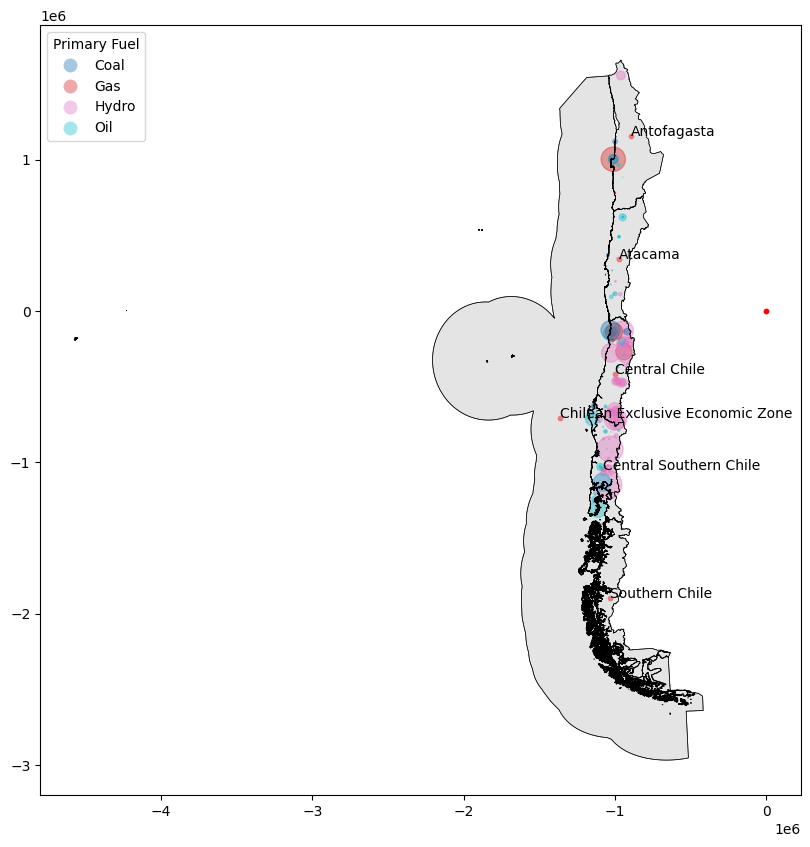

In [371]:
# Convert buses to a GeoDataFrame after the loop
gdf_buses = gpd.GeoDataFrame(n.buses, geometry=gpd.points_from_xy(n.buses.x, n.buses.y))
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 10))

# Plotting
gdf_buses.plot(ax=ax,marker="o", color="red", markersize=10)


# Plot the boundaries of the aggregated regions with a specified line width
aggregated_regions.boundary.plot(ax=ax, color="black", linewidth=0.5)

# Plot the base layer (Chile regions) without specifying the column to use the default geometry
aggregated_regions.plot(ax=ax, color="lightgrey",alpha=0.6)

# Plot the boundaries of the aggregated regions with a specified line width
aggregated_regions.boundary.plot(ax=ax, color="black", linewidth=0.5,alpha=0.6)

# Ensure pwp_chile GeoDataFrame is in the same CRS as aggregated_regions
pwp_chile = pwp_chile.to_crs(aggregated_regions.crs)

for idx, row in aggregated_points.iterrows():
    # Get the centroid of each region
    centroid = row["geometry"]
    # Annotate the plot with the region's NAME_1 at its centroid
    ax.text(centroid.x, centroid.y, row['region'], fontsize=10, ha='left')

# Plot pwp_chile with size based on estimated generation and color based on primary fuel
pwp_chile[pwp_chile["estimated_generation_gwh_2017"]>0].plot(
    ax=ax,
    column="primary_fuel",
    markersize=pwp_chile['estimated_generation_gwh_2017']/10,  # Adjust as necessary
    legend=True,
    legend_kwds={'title': 'Primary Fuel', 'loc': 'upper left'},
    alpha=0.4
    # Add a legend for primary_fuel categories
    # Color map for primary_fuel categories, adjust as needed
)


plt.show()


### Add Renewable Generation

#### Adding Offshore

In [390]:
tsOffshore = pd.read_csv("./data/A_Offshore.csv")
tsOffshore.index = pd.to_datetime(tsindex)
tsOffshore = tsOffshore.resample(f"{resolution}h").first()


In [ ]:
region = "Chilean Exclusive Economic Zone"
n.add("Generator",
    f"{region} OffWind",
    bus=region,
    carrier="offwind",
    p_max_pu=tsOffshore[region],
    marginal_cost=costs.at["offwind", "VOM"],
    capital_cost=costs.at["offwind", "capital_cost"],
    efficiency=costs.at["offwind", "efficiency"]
)
           

#### Adding Onshore Wind

In [388]:
tsOnshore = pd.read_csv("./data/A_Wind.csv")
tsOnshore.index = pd.to_datetime(tsindex)
tsOnshore.index = tsOnshore.index
tsOnshore = tsOnshore.resample(f"{resolution}h").first()

In [389]:
for region, data in tsOnshore.items():
    n.add(
        "Generator",
        f"{region} OnWind",
        bus=region,
        carrier="onwind",
        p_max_pu=tsOnshore[region],
        marginal_cost=costs.at["onwind", "VOM"],
        capital_cost=costs.at["onwind", "capital_cost"],
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )

In [392]:
# Function to manually adjust specific timestamps
def adjust_ambiguous_times(index,timestampss):
    adjusted_index = []
    for ts in index:
        # Example: Adjusting a specific ambiguous timestamp
        if ts == pd.Timestamp(timestampss):
            # Adjust by adding an hour, or whatever is appropriate for your data
            adjusted_ts = ts - pd.Timedelta(hours=3)
            adjusted_index.append(adjusted_ts)
        else:
            adjusted_index.append(ts)
    return pd.DatetimeIndex(adjusted_index)

#### Adding Solar Power

In [393]:
tsSolar = pd.read_csv("./data/A_Solar.csv")
tsSolar.index = pd.DatetimeIndex(tsindex)
tsSolar = tsSolar.resample(f"{resolution}h").first()

<Axes: xlabel='time'>

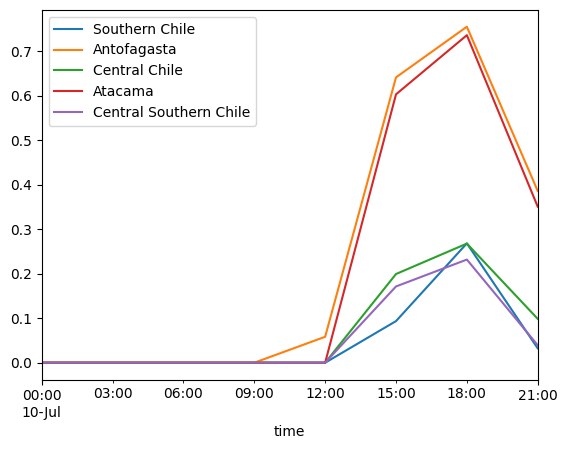

In [394]:
tsSolar.loc["2013-07-10"].plot()

In [395]:
tsSolar = tsSolar[~tsSolar.index.duplicated(keep='first')]

In [396]:
# Adding Solar Power
for region, data in tsSolar.items():
    n.add(
        "Generator",
        f"{region} Solar",
        bus=region,
        carrier="solar",
        p_max_pu=tsSolar[region],
        marginal_cost=costs.at["solar", "VOM"],
        capital_cost=costs.at["solar", "capital_cost"],
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )

#### Check

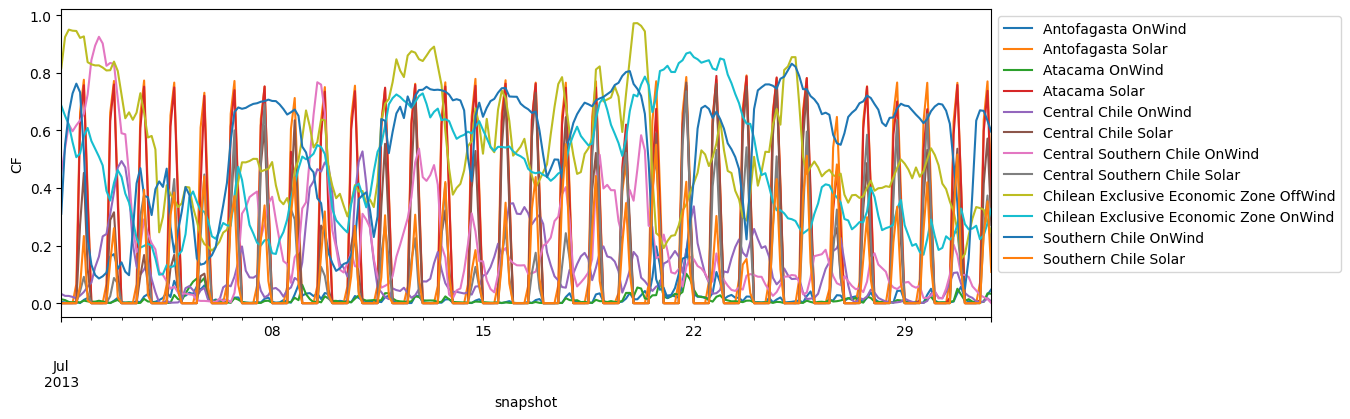

In [398]:
# Assuming n.generators_t.p_max_pu.loc["2013-12"] is your data series
# Plotting the data
ax = n.generators_t.p_max_pu.loc["2013-7"].plot(figsize=(12, 4), ylabel="CF")

# Getting the legend from the plot
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Showing the plot
plt.show()

##### Adding Battery Storage

In [74]:
for row in aggregated_regions.iterrows():
    n.add(
        "StorageUnit",
        f"{row[1].aggRegion} battery storage",
        bus=row[1].aggRegion,
        carrier="battery storage",
        max_hours=6,
        capital_cost=costs.at["battery inverter", "capital_cost"] + 6 * costs.at["battery storage", "capital_cost"],
        efficiency_store=costs.at["battery inverter", "efficiency"],
        efficiency_dispatch=costs.at["battery inverter", "efficiency"],
        p_nom_extendable=True,
        cyclic_state_of_charge=True)

NameError: name 'n' is not defined

##### Adding Hydorge Storage

In [424]:
# Add an option to build hydrogen storage as StorageUnit with an energy-to-power ratio of 336h.
capital_costs = (
    costs.at["electrolysis", "capital_cost"] +
    costs.at["fuel cell", "capital_cost"] +
    336 * costs.at["hydrogen storage underground", "capital_cost"]
)


for row in aggregated_regions.iterrows():
    n.add(
        "StorageUnit",
        f"{row[1].aggRegion} hydrogen storage underground",
        bus=row[1].aggRegion,
        carrier="hydrogen storage underground",
        max_hours=336,
        capital_cost=capital_costs,
        efficiency_store=costs.at["electrolysis", "efficiency"],
        efficiency_dispatch=costs.at["fuel cell", "efficiency"],
        p_nom_extendable=True,
        cyclic_state_of_charge=True,
)

In [ ]:
n.optimize(solver_name="gurobi")

In [ ]:
n.export_to_netcdf("postnetwork.nc")